In [1]:
# https://www.kaggle.com/c/whale-categorization-playground

path = '/notebook/kaggle/'
HOME_DIR = path + 'data/whale_categorization/'
DATA_DIR = HOME_DIR # + 'sample/'
RESULTS_DIR = DATA_DIR + 'results/'
TRAIN_DIR = DATA_DIR + 'train/'
VAL_DIR = DATA_DIR + 'valid/'
TEST_DIR = DATA_DIR + 'test/'

In [2]:
!echo $CUDA_VISIBLE_DEVICES # Should be 0

0


In [17]:
import json
import os
import random
from PIL import Image
#import os, json, glob, shutil
# from skimage.transform import resize
# from skimage.io import imsave, imread
import numpy as np
import pandas as pd
# from matplotlib import pyplot as plt
# import math
import matplotlib.pylab as plt

import keras
from keras.models import Sequential, Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
# from keras.optimizers import SGD, RMSprop, Adam, Nadam
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
# from keras.regularizers import l2, l1
# from keras import backend as K
from keras.layers.core import Flatten, Dense, Dropout, Lambda
# from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
# from keras.applications import VGG19, ResNet50
# from keras.applications.xception import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

%matplotlib inline

In [4]:
with open(path+'kaggle.txt') as json_file:  
    kg_data = json.load(json_file)
    
username = kg_data['username']
password = kg_data['password']

!kg config -g -u $username -p $password -c 'whale-categorization-playground'

#%cd $HOME_DIR
#!kg download
#%cd $path

# import zipfile
# zip = zipfile.ZipFile(HOME_DIR+'test.zip')
# zip.extractall(HOME_DIR)

# zip = zipfile.ZipFile(HOME_DIR+'train.zip')
# zip.extractall(HOME_DIR)

#### Data set-up

In [5]:
# Load training labels
labels = pd.read_csv(HOME_DIR+'train.csv')
imageId_dict = dict(zip(labels['Image'], labels['Id']))

# Count files in training vs. validation sets
train_files = os.listdir(TRAIN_DIR) # Get list of image files
print('# of training images: '+str(len(train_files)))
val_files = os.listdir(VAL_DIR)
print('# of validation images: '+str(len(val_files)))
test_files = os.listdir(TEST_DIR)
print('# of test images: '+str(len(test_files)))

trainId_dict = dict(zip(train_files,[imageId_dict[im] for im in train_files]))

# of training images: 8373
# of validation images: 1477
# of test images: 15610


#### Enforce training/validation split
- Split training and validation data such that a percentage of images in the validation set are not in the training set

In [6]:
# Enforce train/validate split
validation_split = 0.15

# Check difference between number of files in training v. validation set
target_val_size = int((len(train_files)+len(val_files))*validation_split)
split_diff = target_val_size-len(val_files)

if (split_diff>0):
    
    print('Moving '+str(split_diff)+' files')
    
    for file_name in random.sample(train_files, split_diff):
        full_file_name = os.path.join(TRAIN_DIR, file_name)

        if (os.path.isfile(full_file_name)):
            %mv $full_file_name $VAL_DIR
            
    # Count files in each set again (after train/validate split above)
    train_files = os.listdir(TRAIN_DIR) # Get list of image files
    print('# of training images: '+str(len(train_files)))
    val_files = os.listdir(VAL_DIR)
    print('# of validation images: '+str(len(val_files)))        

#### Import images 
- with a resizing and a black and white conversion

In [7]:
im_sz = 64 # New image size

def ImportImage(filename):
    img = Image.open(filename).convert("LA").resize((im_sz, im_sz))
    return np.array(img)[:,:,0]

x_train = np.array([ImportImage(TRAIN_DIR + img_name) for img_name in train_files]) # Training data
#x_valid = np.array([ImportImage(VAL_DIR + img_name) for img_name in val_files]) # Validation data
#x_test = np.array([ImportImage(TEST_DIR + img_name) for img_name in test_files]) # Validation data

In [8]:
# class LabelOneHotEncoder():
#     def __init__(self):
#         self.ohe = OneHotEncoder()
#         self.le = LabelEncoder()
#     def fit_transform(self, x):
#         features = self.le.fit_transform(x)
#         return self.ohe.fit_transform(features.reshape(-1,1))
#     def transform(self, x):
#         return self.ohe.transform(self.la.transform(x.reshape(-1,1)))
#     def inverse_tranform(self, x):
#         return self.le.inverse_transform(self.ohe.inverse_tranform(x))
#     def inverse_labels(self, x):
#         return self.le.inverse_transform(x)

# y = list(map(imageId_dict.get, train_files))
# lohe = LabelOneHotEncoder()
# y_cat = lohe.fit_transform(y)
# print(y_cat[:15])

#### Encode target labels

In [9]:
# Instantiate objects
ohe = OneHotEncoder()
le = LabelEncoder()
    
def train_encoder(filename_list):
    '''Uses a composition of a LabelEncoder and OneHotEncoder to one hot encode the target labels'''
    y = list(map(trainId_dict.get, filename_list))
    #y = list(map(imageId_dict.get, filename_list))
    features = le.fit_transform(y)
    features = features.reshape(-1,1)
    y_encoded = ohe.fit_transform(features)
    return(y_encoded)

y_train = train_encoder(train_files)

#y_validate = train_encoder(val_files)

#y_test = train_encoder(test_files)

#y_test.toarray()[0]
# labels['Id'].head()
# trainId_dict.values()[:5]

In [10]:
# Construct class weights
WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : le.inverse_tranform([[x]])

# Get counts for each label (i.e. whale)
CountDict = dict(pd.Series(trainId_dict.values()).value_counts())
class_weight_dic = { le.transform( [image_name])[0] : WeightFunction(count) for image_name, count in CountDict.items()}
del CountDict

In [11]:
class_weight_dic

{0: 0.0075013540884303559,
 1: 0.43869133765083085,
 2: 1.0,
 3: 0.59460355750136051,
 4: 1.0,
 5: 1.0,
 6: 0.59460355750136051,
 7: 1.0,
 8: 0.59460355750136051,
 9: 0.59460355750136051,
 10: 1.0,
 11: 0.59460355750136051,
 12: 1.0,
 13: 0.59460355750136051,
 14: 1.0,
 15: 0.59460355750136051,
 16: 0.59460355750136051,
 17: 1.0,
 18: 1.0,
 19: 1.0,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 1.0,
 24: 1.0,
 25: 1.0,
 26: 0.59460355750136051,
 27: 1.0,
 28: 1.0,
 29: 1.0,
 30: 0.43869133765083085,
 31: 1.0,
 32: 1.0,
 33: 0.59460355750136051,
 34: 0.59460355750136051,
 35: 1.0,
 36: 1.0,
 37: 1.0,
 38: 0.59460355750136051,
 39: 1.0,
 40: 1.0,
 41: 1.0,
 42: 1.0,
 43: 0.59460355750136051,
 44: 0.59460355750136051,
 45: 1.0,
 46: 1.0,
 47: 0.59460355750136051,
 48: 0.59460355750136051,
 49: 0.43869133765083085,
 50: 0.59460355750136051,
 51: 0.43869133765083085,
 52: 1.0,
 53: 0.43869133765083085,
 54: 1.0,
 55: 0.23236808024254083,
 56: 1.0,
 57: 0.59460355750136051,
 58: 1.0,
 59: 0.59460355750

#### Visualize images

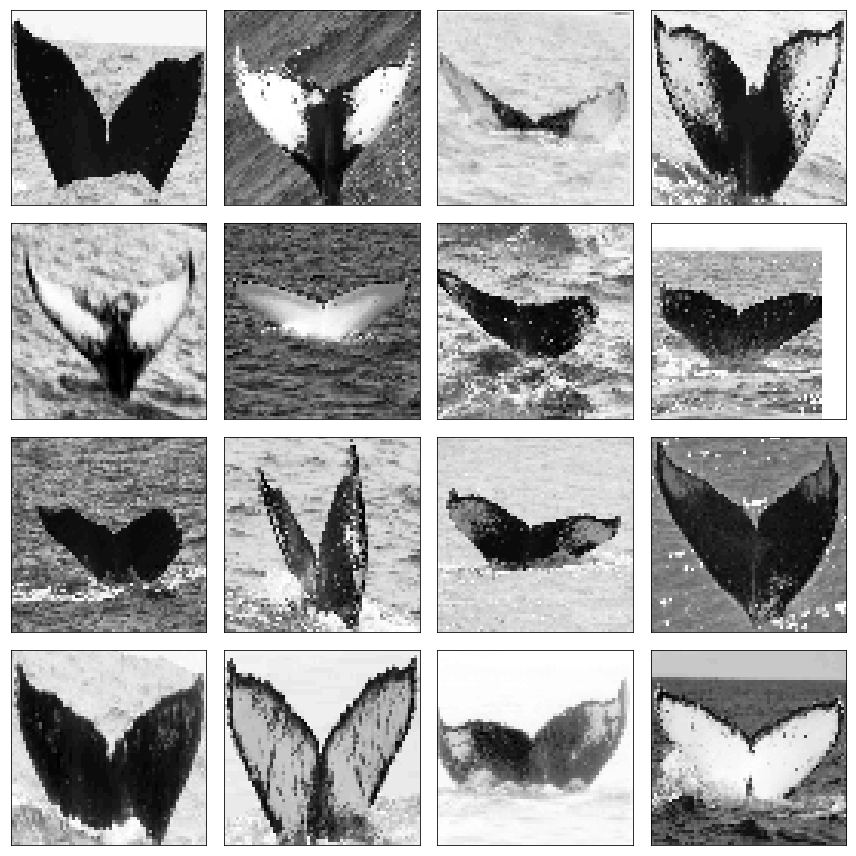

In [12]:
def plotImages(images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        if img.ndim != 2:
            img = img.reshape((im_sz,im_sz))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    
# Plot training images after resizing and BW conversion
plotImages(x_train)

#### Image augmentation 
- with Keras prebuilt

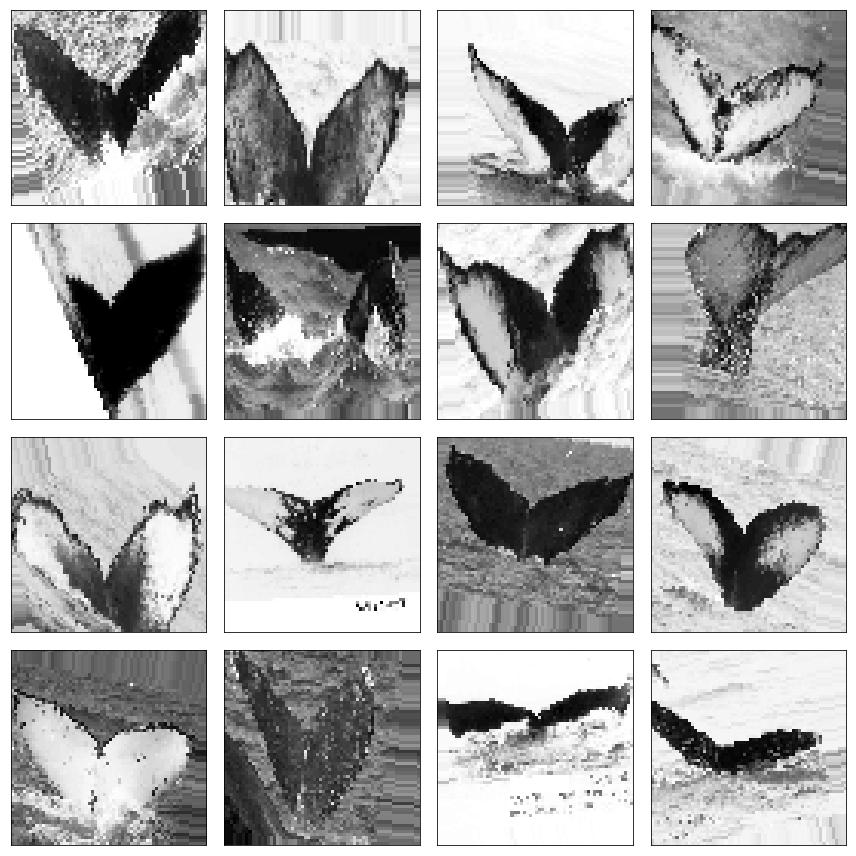

In [14]:
# Use an image generator for preprocessing and data augmentation
x_train = x_train.reshape((-1,im_sz,im_sz,1))
input_shape = x_train[0].shape
x_train = x_train.astype("float32")

image_gen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

# Fit the generator
image_gen.fit(x_train, augment=True)

# Visualize some preprocessed images
augmented_images, _ = next(image_gen.flow(x_train, y_train.toarray(), batch_size=4*4))
plotImages(augmented_images)

#### Building and training model

In [18]:
batch_size = 128
num_classes = len(y_train.toarray()[0])
epochs = 9

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

model = Sequential()
model.add(Conv2D(48, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(48, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.33))
model.add(Flatten())
model.add(Dense(36, activation='sigmoid'))
model.add(Dropout(0.33))
model.add(Dense(36, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()
model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
          steps_per_epoch=  x_train.shape[0]//batch_size,
          epochs=epochs,
          verbose=1,
          class_weight=class_weight_dic)

## STILL NEED TO IMPLEMENT THIS!
#score = model.evaluate(x_train, y_train, verbose=0)
#print('Training loss: {0:.4f}\nTraining accuracy:  {1:.4f}'.format(*score))

('x_train shape:', (8373, 64, 64, 1))
(8373, 'train samples')
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 48)        480       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 48)        20784     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 48)        57648     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 48)          0         
_________________________________________________________________
flatten_2 (Fla

#### Predictions on test samples and export for submission

In [ ]:
## STILL NEED TO IMPLEMENT THIS!
import warnings
from os.path import split

with open("sample_submission.csv","w") as f:
    with warnings.catch_warnings():
        f.write("Image,Id\n")
        warnings.filterwarnings("ignore",category=DeprecationWarning)
        for image in test_images:
            img = ImportImage( image)
            x = img.astype( "float32")
            #applying preprocessing to test images
            x = image_gen.standardize( x.reshape(1,SIZE,SIZE))
            
            y = model.predict_proba(x.reshape(1,SIZE,SIZE,1))
            predicted_args = np.argsort(y)[0][::-1][:5]
            predicted_tags = lohe.inverse_labels( predicted_args)
            image = split(image)[-1]
            predicted_tags = " ".join( predicted_tags)
            f.write("%s,%s\n" %(image, predicted_tags))